<a href="https://colab.research.google.com/github/YugantGotmare/Face_Emotion_Recognition/blob/master/face_Emotion_regconation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

100% 120M/121M [00:06<00:00, 17.3MB/s]
100% 121M/121M [00:06<00:00, 18.6MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/face-expression-recognition-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D,BatchNormalization, LSTM, CuDNNLSTM, MaxPooling2D, SimpleRNN
from keras.models import Sequential
from keras import regularizers
import keras

from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import os
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
folder_path = '/content/images/train'

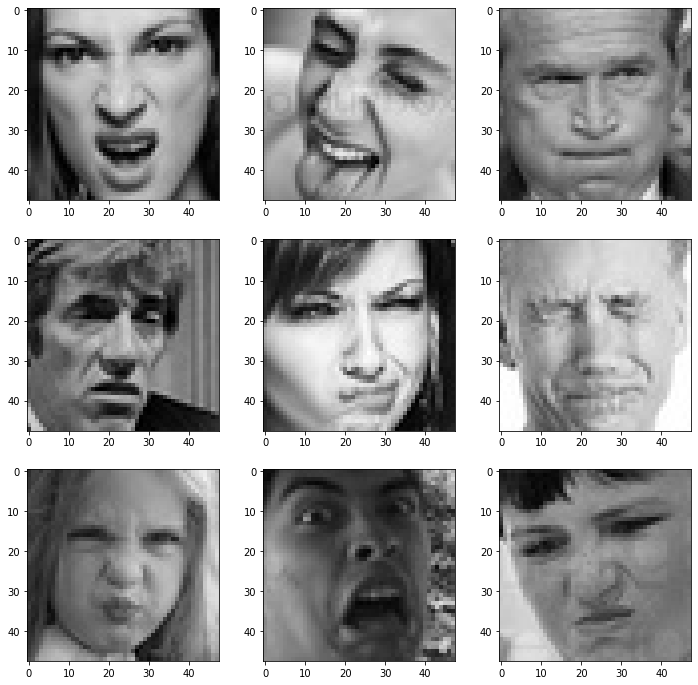

In [ ]:
expression = 'disgust'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"/"+expression+"/"+
                  os.listdir(folder_path + "/" + expression)[i], target_size=(48, 48))
    plt.imshow(img)   
plt.show()

In [ ]:
image_generator = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=2, 
    vertical_flip=2
)    

training_set = image_generator.flow_from_directory(batch_size=256,
                                                 directory='/content/images/train',
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                )

testing_set = image_generator.flow_from_directory(batch_size=128,
                                                 directory='/content/images/validation',
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                 )

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
dim = (48,48) 
n_sequence = 8 
n_channels = 3 
n_output = 7 

In [ ]:
model = Sequential()    
model.add(tf.keras.layers.Reshape((1, 48, 48, 3), input_shape=(48, 48, 3)))
model.add( 
    TimeDistributed(
        MobileNetV2(weights='imagenet',include_top=False), 
        input_shape=(n_sequence, *dim, n_channels)
    )
)
model.add(
    TimeDistributed(
        GlobalAveragePooling2D()
    )
)
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(24, activation='relu'))
model.add(Dropout(.5))  
model.add(Dense(n_output, activation='softmax'))

In [ ]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]

In [ ]:
model.compile(optimizer = "adam",loss = "categorical_crossentropy" , metrics=['accuracy'])
hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 30, callbacks=call_back)

Epoch 1/30


<ipython-input-61-7eee3653204e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 30, callbacks=call_back)


113/113 [==============================] - ETA: 0s - loss: 1.8615 - accuracy: 0.2270
Epoch 1: val_accuracy improved from -inf to 0.25856, saving model to best_model.h5
113/113 [==============================] - 27s 168ms/step - loss: 1.8615 - accuracy: 0.2270 - val_loss: 1.8423 - val_accuracy: 0.2586
Epoch 2/30
113/113 [==============================] - ETA: 0s - loss: 1.7040 - accuracy: 0.3201
Epoch 2: val_accuracy improved from 0.25856 to 0.33046, saving model to best_model.h5
113/113 [==============================] - 14s 126ms/step - loss: 1.7040 - accuracy: 0.3201 - val_loss: 1.7504 - val_accuracy: 0.3305
Epoch 3/30
113/113 [==============================] - ETA: 0s - loss: 1.5850 - accuracy: 0.3908
Epoch 3: val_accuracy did not improve from 0.33046
113/113 [==============================] - 14s 120ms/step - loss: 1.5850 - accuracy: 0.3908 - val_loss: 1.6870 - val_accuracy: 0.3126
Epoch 4/30
113/113 [==============================] - ETA: 0s - loss: 1.4998 - accuracy: 0.4354
Epoch

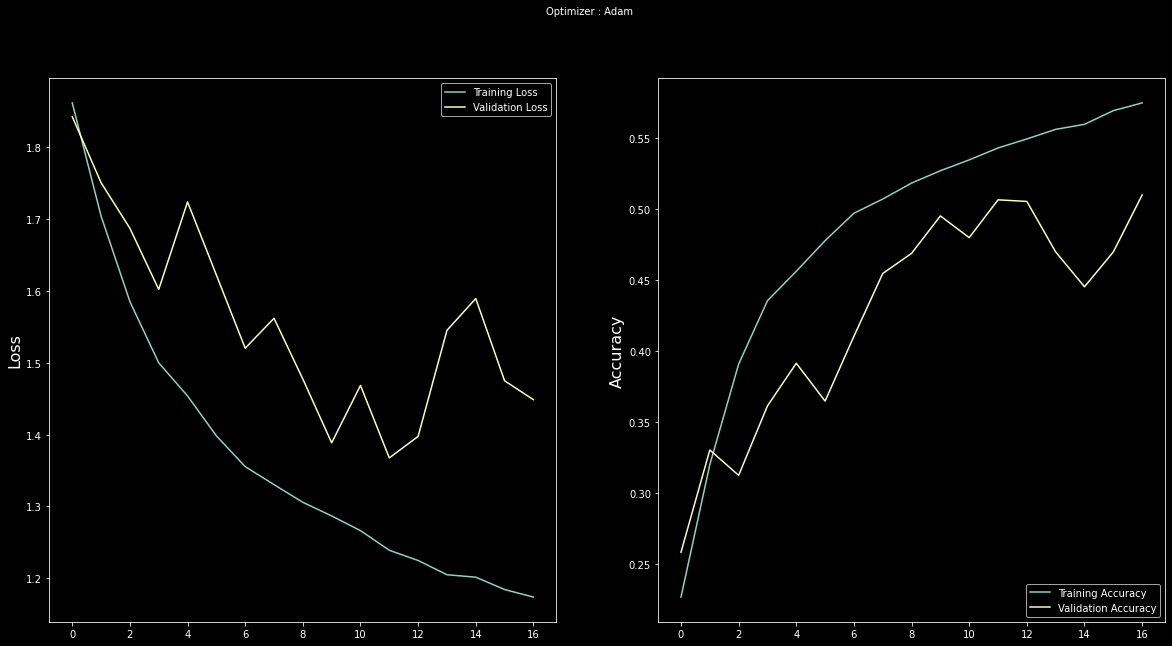

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
hist = hist.history

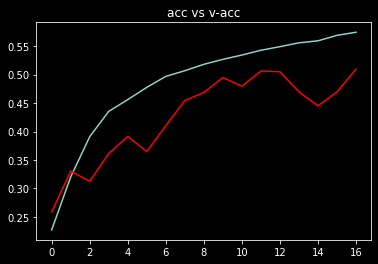

In [ ]:
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

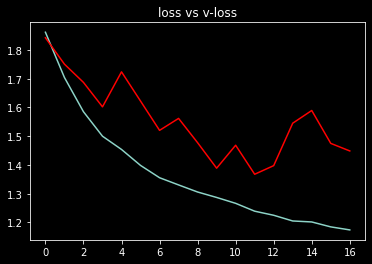

In [ ]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()